In [222]:
import sqlite3
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

### Creating a SQLite Database

In [220]:
data_df = pd.read_csv('./data/car_price.csv')
conn = sqlite3.connect('db/prices.db')
data_df.to_sql('cars', conn, if_exists='replace', index=False)

15915

In [280]:
data_df.head(10)

,make_model,body_type,price,vat,km,Type,Fuel,Gears,Comfort_Convenience,Entertainment_Media,...,Previous_Owners,hp_kW,Inspection_new,Paint_Type,Upholstery_type,Gearing_Type,Displacement_cc,Weight_kg,Drive_chain,cons_comb
0,Audi A1,Sedans,15770,VAT deductible,56013.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",...,2.0,66.0,1,Metallic,Cloth,Automatic,1422.0,1220.0,front,3.8
1,Audi A1,Sedans,14500,Price negotiable,80000.0,Used,Benzine,7.0,"Air conditioning,Automatic climate control,Hil...","Bluetooth,Hands-free equipment,On-board comput...",...,1.0,141.0,0,Metallic,Cloth,Automatic,1798.0,1255.0,front,5.6
2,Audi A1,Sedans,14640,VAT deductible,83450.0,Used,Diesel,7.0,"Air conditioning,Cruise control,Electrical sid...","MP3,On-board computer",...,1.0,85.0,0,Metallic,Cloth,Automatic,1598.0,1135.0,front,3.8
3,Audi A1,Sedans,14500,VAT deductible,73000.0,Used,Diesel,6.0,"Air suspension,Armrest,Auxiliary heating,Elect...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.0,66.0,0,Metallic,Cloth,Automatic,1422.0,1195.0,front,3.8
4,Audi A1,Sedans,16790,VAT deductible,16200.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,MP3,O...",...,1.0,66.0,1,Metallic,Cloth,Automatic,1422.0,1135.0,front,4.1
5,Audi A1,Sedans,15090,VAT deductible,63668.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,Hands-free equipment,On-board comput...",...,1.0,85.0,0,Metallic,Part/Full Leather,Automatic,1598.0,1135.0,front,3.5
6,Audi A1,Station wagon,16422,VAT deductible,62111.0,Used,Diesel,7.0,"Air conditioning,Armrest,Automatic climate con...","Bluetooth,CD player,Hands-free equipment,On-bo...",...,1.0,85.0,1,Metallic,Part/Full Leather,Automatic,1598.0,1195.0,front,3.7
7,Audi A1,Compact,14480,VAT deductible,14986.0,Used,Diesel,7.0,"Air conditioning,Armrest,Electrical side mirro...","CD player,MP3,Radio",...,1.0,66.0,1,Metallic,Cloth,Automatic,1422.0,1180.0,front,3.7
8,Audi A1,Sedans,16700,VAT deductible,57000.0,Used,Diesel,7.0,"Air conditioning,Power windows",Radio,...,1.0,85.0,0,Metallic,Cloth,Automatic,1598.0,1275.0,front,3.7
9,Audi A1,Sedans,17990,VAT deductible,16103.0,Used,Benzine,7.0,"Air conditioning,Armrest,Automatic climate con...",Radio,...,1.0,70.0,0,Metallic,Cloth,Automatic,999.0,1135.0,front,4.2


### Creating a SQLCoderQueryGenerator Class

In [270]:
class SQLCoderQueryGenerator:
    def __init__(self, db_path, model, api_endpoint):
        self.db_path = db_path
        self.model = model
        self.api_endpoint = api_endpoint

    def get_table_sample_data(self, num_rows=2):
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()

        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        table_samples = {}
        for table in tables:
            table_name = table[0]

            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = cursor.fetchall()
            column_names = [col[1] for col in columns]

            cursor.execute(f"SELECT * FROM {table_name} LIMIT {num_rows}")
            rows = cursor.fetchall()

            sample_data = [
                dict(zip(column_names, row))
                for row in rows
            ]

            table_samples[table_name] = {
                'columns': column_names,
                'sample_rows': sample_data
            }

        conn.close()
        return table_samples

    def get_database_schema(self):
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()

        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        schema_info = ""
        for table in tables:
            table_name = table[0]
            schema_info += f"Table: {table_name}\n"

            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = cursor.fetchall()

            for column in columns:
                schema_info += f"  - {column[1]} ({column[2]})\n"
            schema_info += "\n"

        conn.close()
        return schema_info

    def generate_rag_prompt(self, natural_language_query, database_schema, table_samples):
        rag_prompt = """
        ### Instructions:
        Your task is to convert a natural language question into a SQL query using the provided database schema and sample data.

        Adhere to the following rules:
        - Analyze the schema and sample data carefully to construct a meaningful query.
        - Use table aliases to ensure clarity and prevent ambiguity.
        - Limit the results to a maximum of 100 rows.
        - Use aggregation functions like SUM or COUNT where necessary.
        - Return **only** the SQL query, and ensure it is syntactically correct.
        \n"""

        rag_prompt += "### Database Schema:\n"
        rag_prompt += database_schema.strip() + "\n\n"

        rag_prompt += "### Sample Table Data:\n"
        for table_name, table_info in table_samples.items():
            rag_prompt += f"Table: {table_name}\n"
            rag_prompt += "Columns: " + ", ".join(table_info['columns']) + "\n"
            rag_prompt += "Sample Rows:\n"
            rag_prompt += json.dumps(table_info['sample_rows'], indent=2) + "\n\n"

        rag_prompt += f"""
        ### Generate SQL Query:
        Based on the above information, generate a SQL query to answer the following natural language question:
        "{natural_language_query}"

        ### SQL Guidelines:
        - Use only SELECT queries.
        - Be precise and specific in your query.
        - Use table aliases where appropriate.
        - Ensure the query is meaningful and syntactically correct.
        """

        return rag_prompt.strip()

    def validate_sql_query(self, sql_query):
        conn = sqlite3.connect(self.db_path)
        cursor = conn.cursor()

        try:
            cursor.execute(sql_query)
            conn.close()
            return sql_query
        except sqlite3.Error as e:
            error_message = str(e)
            print(f"SQL Query Validation Error: {error_message}")

            correction_prompt = f"""
            Original SQL Query: {sql_query}
            Error Message: {error_message}

            Diagnose the SQL query error and provide a corrected version.
            Ensure the corrected query:
            1. Is syntactically correct
            2. Matches the original query's intent
            3. Works with the database schema
            4. Returns meaningful results

            Return ONLY the corrected SQL query.
            """

            try:
                response = requests.post(
                    self.api_endpoint,
                    json={
                        'model': self.model,
                        'prompt': correction_prompt,
                        'stream': False
                    }
                )

                result = response.json()
                corrected_query = result['response'].strip()

                cursor.execute(corrected_query)
                conn.close()

                print("Query corrected successfully.")
                return corrected_query

            except Exception as correction_error:
                print(f"Could not correct query: {correction_error}")
                conn.close()
                return ""

    def generate_sql_query(self, natural_language_query):
        database_schema = self.get_database_schema()
        table_samples = self.get_table_sample_data()

        rag_prompt = self.generate_rag_prompt(
            natural_language_query,
            database_schema,
            table_samples
        )

        try:
            response = requests.post(
                self.api_endpoint,
                json={
                    'model': self.model,
                    'prompt': rag_prompt,
                    'stream': False
                }
            )

            result = response.json()
            sql_query = result['response'].strip()

            # Optional: Validate the query
            validated_query = self.validate_sql_query(sql_query)

            return validated_query

        except Exception as e:
            print(f"Error generating SQL query: {e}")
            return ""

    def execute_sql_query(self, sql_query):
        conn = sqlite3.connect(self.db_path)

        try:
            cursor = conn.cursor()
            cursor.execute(sql_query)

            column_names = [description[0] for description in cursor.description]

            results = cursor.fetchall()

            result_dicts = [
                dict(zip(column_names, row))
                for row in results
            ]

            return result_dicts

        except sqlite3.Error as e:
            print(f"SQL Error: {e}")
            return []
        finally:
            conn.close()

    def interpret_result(self, results, natural_language_query, sql_query):
        if not results:
            return f"The query '{natural_language_query}' returned no results. Executed SQL: {sql_query}"

        num_rows = len(results)
        columns = list(results[0].keys())
        sample_rows = results[:5]

        ollama_prompt = f"""
        Context for SQL Query Results Analysis:
        - **Natural Language Query**: '{natural_language_query}'
        - **Executed SQL Query**:
        ```sql
        {sql_query}
        ```

        Results Summary:
        - Total rows: {num_rows}
        - Columns: {', '.join(columns)}
        - Sample rows (up to 5 shown):
        {json.dumps(sample_rows, indent=2)}

        Task for Ollama:
        1. Summarize the results. Use concise, non-technical language that is easy to understand.
        2. Do not explain your reasoning or provide additional context. Do not talk about the SQL query.
        3. Maximum response length: 3-4 sentences.
        """

        try:
            response = requests.post(
                self.api_endpoint,
                json={
                    'model': self.model,
                    'prompt': ollama_prompt,
                    'stream': False
                }
            )

            result = response.json()
            ollama_summary = result.get('response', '').strip()

            if not ollama_summary:
                return "Ollama did not provide a valid summary."

            return ollama_summary

        except Exception as e:
            return f"Error using Ollama for result interpretation: {str(e)}"

    def suggest_plot_axes(self, results, sql_query):
        if not results:
            return None, None

        columns = list(results[0].keys())

        llm_prompt = f"""
        Based on the following SQL query and its results, suggest the best columns for plotting:
        - **SQL Query**:
        ```sql
        {sql_query}
        ```

        - **Results Columns**: {', '.join(columns)}

        Task:
        1. Suggest the most meaningful column for the x-axis.
        2. Suggest the most meaningful column for the y-axis.
        3. Explain your reasoning in 1-2 sentences.
        """

        try:
            response = requests.post(
                self.api_endpoint,
                json={
                    'model': self.model,
                    'prompt': llm_prompt,
                    'stream': False
                }
            )

            result = response.json()

            llm_suggestion = result.get('response', '').strip()

            # Parse the response to extract x_axis and y_axis
            x_axis = None
            y_axis = None

            # Split the suggestion text into lines for processing
            lines = llm_suggestion.split("\n")

            for line in lines:
                line = line.strip()

                # Check for x-axis definition
                if "x-axis" in line.lower():
                    if ":" in line:
                        x_axis = line.split("x-axis:")[-1].strip(" `")

                # Check for y-axis definition
                elif "y-axis" in line.lower():
                    if ":" in line:
                        y_axis = line.split("y-axis:")[-1].strip(" `")

            x_axis = x_axis.replace("**", "")
            y_axis = y_axis.replace("**", "")


            return x_axis, y_axis

        except Exception as e:
            print(f"Error using LLM for axis suggestion: {e}")
            return None, None

    def plot_results(self, results, sql_query, plot_type="auto"):
        if not results:
            return "No data to plot."

        x_axis, y_axis = self.suggest_plot_axes(results, sql_query)

        if not x_axis or not y_axis:
            return "Could not determine x and y axes for plotting."

        try:
            df = pd.DataFrame(results)

            if plot_type == "auto":
                plot_type = "scatter" if pd.api.types.is_numeric_dtype(df[y_axis]) else "bar"

            plt.figure(figsize=(8, 6))
            if plot_type == "bar":
                df.groupby(x_axis)[y_axis].sum().plot(kind="bar")
            elif plot_type == "line":
                df.plot(x=x_axis, y=y_axis, kind="line")
            elif plot_type == "scatter":
                df.plot(x=x_axis, y=y_axis, kind="scatter")
            else:
                return f"Plot type '{plot_type}' is not supported."

            plt.title(f"{y_axis} vs {x_axis} ({plot_type.title()} Plot)")
            plt.xlabel(x_axis)
            plt.ylabel(y_axis)

            plot_path = "./result_plot.png"
            plt.savefig(plot_path)
            plt.close()

            return f"Plot successfully generated and saved to {plot_path}"

        except Exception as e:
            return f"Error creating plot: {str(e)}"

    def plot_results(self, results, sql_query, x_axis=None, y_axis=None, plot_type="auto"):
        if not results:
            return "No data to plot."

        if not x_axis or not y_axis:
            x_axis, y_axis = self.suggest_plot_axes(results, sql_query)

        if not x_axis or not y_axis:
            return "Could not determine x and y axes for plotting."

        try:
            df = pd.DataFrame(results)

            if plot_type == "auto":
                plot_type = "scatter" if pd.api.types.is_numeric_dtype(df[y_axis]) else "bar"

            plt.figure(figsize=(8, 6))
            if plot_type == "bar":
                df.groupby(x_axis)[y_axis].sum().plot(kind="bar")
            elif plot_type == "line":
                df.plot(x=x_axis, y=y_axis, kind="line")
            elif plot_type == "scatter":
                df.plot(x=x_axis, y=y_axis, kind="scatter")
            else:
                return f"Plot type '{plot_type}' is not supported."

            plt.title(f"{y_axis} vs {x_axis} ({plot_type.title()} Plot)")
            plt.xlabel(x_axis)
            plt.ylabel(y_axis)

            plot_path = "query_results_plot.png"
            plt.savefig(plot_path)
            plt.close()

            return f"Plot successfully generated and saved to {plot_path}"

        except Exception as e:
            return f"Error creating plot: {str(e)}"

### Testing the SQLCoderQueryGenerator Class

In [273]:

generator = SQLCoderQueryGenerator(db_path='db/prices.db', model='llama3.2:latest',
                                   api_endpoint='http://localhost:11434/api/generate') # OLLAMA Local API Endpoint

natural_language_query = "show me models and average price of cars"

# Generate SQL query
sql_query = generator.generate_sql_query(natural_language_query)
print("*-------------------------------*")
print("Generated SQL Query:", sql_query)
results = generator.execute_sql_query(sql_query)

# Interpret the results
print("*-------------------------------*")
print("Query Results:", results)
interpretation = generator.interpret_result(results, natural_language_query, sql_query)

print("*-------------------------------*")
print("Interpreted Results:")
print(interpretation)

*-------------------------------*
Generated SQL Query: SELECT make_model ,  AVG(price) FROM cars GROUP BY make_model LIMIT 100
*-------------------------------*
Query Results: [{'make_model': 'Audi A1', 'AVG(price)': 18864.688982402447}, {'make_model': 'Audi A2', 'AVG(price)': 28200.0}, {'make_model': 'Audi A3', 'AVG(price)': 20996.693251533743}, {'make_model': 'Opel Astra', 'AVG(price)': 15840.834059405941}, {'make_model': 'Opel Corsa', 'AVG(price)': 11061.841606498196}, {'make_model': 'Opel Insignia', 'AVG(price)': 21463.451886066206}, {'make_model': 'Renault Clio', 'AVG(price)': 11940.32082653616}, {'make_model': 'Renault Duster', 'AVG(price)': 13230.176470588236}, {'make_model': 'Renault Espace', 'AVG(price)': 30080.21190716448}]
*-------------------------------*
Interpreted Results:
Here's a summary of the results:

The list shows cars grouped by model, along with their average price. There are 9 models in total. The Audi models have relatively high prices, while Opel models tend 

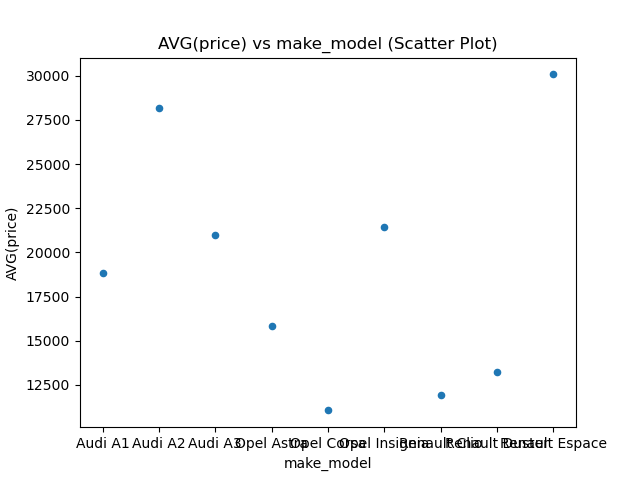

In [279]:
from IPython.display import Image
x_axis, y_axis = generator.suggest_plot_axes(results, sql_query)

generator.plot_results(results, sql_query, x_axis, y_axis, plot_type="auto")
Image(filename='./query_results_plot.png')